# Decision Tree with CART using Information gain, Gini Impurity.

## Understanding the core idea between gini impurity and gini co-efficients. 

* Gini impurity is a measure of misclassification, which applies in a multiclass classifier context.
* Gini coefficient applies to binary classification and requires a classifier that can in some way rank examples according to the likelihood of being in a positive class.

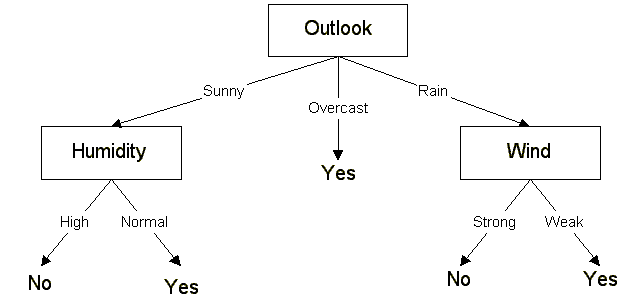

In [1]:
# Toy dataset.
# Format: each row is an example.
# The last column is the label.
# The first two columns are features.
# Feel free to play with it by adding more features & examples.
# Interesting note: I've written this so the 2nd and 5th examples
# have the same features, but different labels - so we can see how the
# tree handles this case.
training_data = [
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]

In [2]:
# Column labels.
# These are used only to print the tree.
header = ["color", "diameter", "label"]

In [3]:
print(header)
training_data

['color', 'diameter', 'label']


[['Green', 3, 'Apple'],
 ['Yellow', 3, 'Apple'],
 ['Red', 1, 'Grape'],
 ['Red', 1, 'Grape'],
 ['Yellow', 3, 'Lemon']]

In [4]:
def unique_vals(rows, col):
    """Find the unique values for a column in a given dataset.
       returns a set of unique values in that column - feature. 
    """
    return set([row_element[col] for row_element in rows])

In [5]:
# get the unique entires in the required cols
unique_vals(training_data,0)

{'Green', 'Red', 'Yellow'}

In [6]:
unique_vals(training_data,1)

{1, 3}

In [7]:
def class_counts(rows):
    """ Counts the number of observations that belong to the final target class. 
        This function assumes the target label is the last column always. """
    
    # class : observation counts
    counts = {}
    
    # for every row check if the element is present & update accordingly.
    for row_element in rows:
        if row_element[-1] not in counts:
            counts[row_element[-1]] = 0
        counts[row_element[-1]]+=1
    return counts

In [8]:
class_counts(training_data)

{'Apple': 2, 'Grape': 2, 'Lemon': 1}

In [9]:
def is_numeric(value):
    """checks if an entry is a number."""
    return isinstance(value, int) or isinstance(value, float)

In [10]:
class Question:
    """A Question is used to partition the dataset.

    This class supports to ask questions on the dataset.
    match() checks if the dataset specified  meets the required condition.
    The condition is usually to check if the datapoint > number in the case of a numerical,
    or equals in case of a string.
    repr() makes the question more understandable - readable.
    """
    
    def __init__(self, column, value):
        self.column = column
        self.value = value
    
    def match(self, example):
        """
        example: Sample datapoint to check on.
        """
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        return val == self.value
    
    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = '=='
        
        if is_numeric(self.value):
            condition = '>='
        
        return "Is %s %s %s?" % (
            header[self.column],condition,str(self.value))
            

In [11]:
q = Question(0,'Red')

In [12]:
Question(0,'Yellow').match(training_data[0])

False

In [13]:
def partition(rows, question):
    """Partitions a dataset.

    For each row in the dataset, check if it matches the question. If
    so, add it to 'true rows', otherwise, add it to 'false rows'.
    """
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [14]:
true_rows, false_rows = partition(training_data, Question(0, 'Red'))

In [15]:
false_rows

[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

In [16]:
true_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]

### Gini impurity at a node is the is the chance a randomly selected data point and a randomly selected target label in the dataset are incorrect match - misclassification.

In [17]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    counts = class_counts(rows)    
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [18]:
# what is the sample gini impurity 
gini([['Apple'],
      ['Apple'],
      ['fruit'],
      ['Yellow']])

0.625

In [19]:
gini(training_data)

0.6399999999999999

In [20]:
def info_gain(left, right, current_uncertainty):
    """Information Gain.

    The uncertainty of the starting node, minus the weighted impurity of
    two child nodes.
    """
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - (p*gini(left)+ (1-p)*gini(right))

### How much information do we gain by partioning on 'Green'?

In [21]:
current_uncertainty = gini(training_data)

In [22]:
true_rows, false_rows = partition(training_data, Question(0, 'Green'))
info_gain(true_rows, false_rows, current_uncertainty)

0.1399999999999999

### How much information do we gain by partioning on 'Red'?


In [23]:
true_rows, false_rows = partition(training_data, Question(0, 'Red'))
info_gain(true_rows, false_rows, current_uncertainty)

0.37333333333333324

In [24]:
print(true_rows)
false_rows

[['Red', 1, 'Grape'], ['Red', 1, 'Grape']]


[['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']]

### Finding best split - such that we ask the right question is the challenge, as we can see, it must be automated to ask the right questions and make a splitting decision accordingly.

In [25]:
def find_best_split(rows):
    """
    Iteratively search for the best feature and makes a split accordingly. 
    Returns the best information gain, best question.
    """
    # set an arbitrary lower value to the best information gain. 
    best_ig = 0
    
    # keep a track of the best question
    best_question = None
    
    # track all the features except the last feature of the row which actually is the target label.
    n_features = len(rows[0])-1
    
    # compute the current uncertainity
    current_uncertainty = gini(rows)
    
    # for feature index ask the best questions 
    for feature_idx in range(n_features):
        # get the actual feature in all the features
        for feature_value in unique_vals(rows, feature_idx):
            
            # ask the question based on the feature index and the feature value that
            # is due to the current iteration.
            current_question = Question(feature_idx,feature_value)
            
            # seperated rows based on the current question
            true_rows, false_rows = partition(rows, current_question)
            
            # if there are no partitions then skip
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue
            
            # get the current information gain
            current_gain = info_gain(true_rows, false_rows, current_uncertainty)
            
            # assign the gains accordingly
            if current_gain > best_ig:
                best_ig = current_gain
                best_question = current_question
                
    return best_ig, best_question

In [26]:
find_best_split(training_data)

(0.37333333333333324, Is color == Red?)

In [27]:
class Leaf:
    """A Leaf node classifies data.

    This contains a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)
        
    def __repr__(self):
        return "%s"%(self.predictions)

In [28]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [29]:
def build_tree(rows):
    """ Recursively Builds the tree.

     Start by checking for the base case which is - (no further information gain).
    """

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)
    
    print("-----------")
    print(question)
    print(gain)
    
    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)
    print("True %s " %(true_rows))
    print("False %s " %(false_rows))
    
    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # depending on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [30]:
tree = build_tree(training_data)

-----------
Is color == Red?
0.37333333333333324
True [['Red', 1, 'Grape'], ['Red', 1, 'Grape']] 
False [['Green', 3, 'Apple'], ['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']] 
-----------
None
0
-----------
Is color == Yellow?
0.11111111111111116
True [['Yellow', 3, 'Apple'], ['Yellow', 3, 'Lemon']] 
False [['Green', 3, 'Apple']] 
-----------
None
0
-----------
None
0


In [33]:
def print_tree(node, spacing=""):
    """ Just another tree printing function.
    """

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [34]:
print_tree(tree)

Is color == Red?
--> True:
  Predict {'Grape': 2}
--> False:
  Is color == Yellow?
  --> True:
    Predict {'Apple': 1, 'Lemon': 1}
  --> False:
    Predict {'Apple': 1}
